# Neural Network Data Representation

play with toy data and try and find a good way of representing data for input to a neural network

## TODO

num prediction not working very well - currently cat... try regression or different loss?

- improve target choice
- expand vocab
- simulate later board stages (round 2+)
- predict no. guess 

a bit separate
- predict vector rather than word in vocab? why isn't this done more in language modeling?

In [1]:
import math
import random
from collections import Counter
from itertools import groupby
from statistics import StatisticsError, mode

import numpy as np
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial import distance
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tqdm.auto import tqdm

In [2]:
WV_PATH = "../data/10k_wiki-news-300d-1M-subword.vec"  # 10k subset for dev

In [3]:
%%time
kv = KeyedVectors.load_word2vec_format(WV_PATH)

CPU times: user 2.51 s, sys: 19.7 ms, total: 2.53 s
Wall time: 2.52 s


In [4]:
# very toy vocabs
vocab = ["football", "weather", "technology", "flowers", "mouse"]
vocab2 = ["geography", "food", "happy", "furniture", "tall"]

assert len(vocab) == len(vocab2)

N = len(vocab)

M = 25
# fake news... using stupid numbers here to take a shortcut... want to prove that the representation is meaningful
n_allied = 12
n_enemy = 6
n_neutral = 6
n_assassin = 1

tile_types = ["ally", "enemy", "neutral", "assassin"]
tile_type_scores = [1, -1, 0, -10]

In [5]:
for word in vocab:
    assert word in kv.vocab
for word in vocab2:
    assert word in kv.vocab, f"{word} not in vocab"

In [6]:
class BoardGenerator:
    def __init__(
        self,
        M,
        N,
        kv,
        vocab,
        n_allied,
        n_neutral,
        n_enemy,
        n_assassin,
        tile_types,
        tile_type_scores,
    ):
        self.M = M
        self.N = N
        self.kv = kv
        self.vocab = vocab
        self.n_allied = n_allied
        self.n_neutral = n_neutral
        self.n_enemy = n_enemy
        self.n_assassin = n_assassin
        self.tile_types = tile_types
        self.tile_type_scores = tile_type_scores

        self.v_vocab = [kv.get_vector(word) for word in vocab]
        self.v_most_sim = {
            word: list(zip(*kv.most_similar(word, topn=20)))[0] for word in vocab
        }

    def generate_board_types(self, board_topics):
        """ returns board_tile_types as list(M) and y"""
        # assign tile types - M_allied of ally, enemy, neural, 1 assassin
        board_types = (
            ["ally"] * self.n_allied
            + ["neutral"] * self.n_neutral
            + ["enemy"] * self.n_enemy
            + ["assassin"] * self.n_assassin
        )
        random.shuffle(board_types)  # shuffle

        board_scores = [
            self.tile_type_scores[self.tile_types.index(bt)] for bt in board_types
        ]
        sorted_zipped = sorted(zip(board_scores, board_topics), key=lambda x: x[1])
        summed = dict()
        for k, g in groupby(sorted_zipped, key=lambda x: x[1]):
            weights, _ = list(zip(*g))
            summed[k] = sum(weights)

        # consistent dict order :)
        max_ind = np.argmax(list(summed.values()))  # TODO draws?
        y_topic = list(summed.keys())[max_ind]
        y_count = len(
            [
                i
                for i in range(M)
                if board_types[i] == "ally" and board_topics[i] == y_topic
            ]
        )
        y = (y_topic, y_count)

        return board_types, y

    def generate_board(self):
        board = list()
        board_topics = list()

        for i in range(self.M):
            topic = random.choice(self.vocab)
            similar = self.v_most_sim[topic]

            while (
                word := random.choice(similar)
            ) in board:  # not sure how I feel about these assignment exprs.
                continue  # try again

            # should now have a word that isn't in board
            board.append(word)
            board_topics.append(topic)

        board_types, y = self.generate_board_types(board_topics)

        return board, board_topics, board_types, y

    # In[7]:

    def print_grid(self, board, board_types):
        l = int(math.sqrt(self.M))
        bt = [self.tile_types.index(bt) for bt in board_types]
        bt = np.array(bt).reshape(l, l)

        # "ally", "enemy", "neutral", "assassin"
        cmap = ListedColormap(["g", "r", "w", "k"])

        fig, ax = plt.subplots(figsize=(8, 8),)
        ax.matshow(bt, cmap=cmap)

        for (i, j), z in np.ndenumerate(bt):
            c = (i * l) + j
            ax.text(
                j,
                i,
                board[c],
                ha="center",
                va="center",
                bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
            )

        plt.show()

    def get_repr(self, board):
        x = np.zeros((self.M, self.N), dtype=np.float32)
        for i, word in enumerate(board):
            u = self.kv.get_vector(word)
            for j, v in enumerate(self.v_vocab):
                x[i, j] = 1 - distance.cosine(u, v)

        return x

In [7]:
bg = BoardGenerator(
    M=M,
    N=N,
    kv=kv,
    vocab=vocab,
    n_allied=n_allied,
    n_neutral=n_neutral,
    n_enemy=n_enemy,
    n_assassin=n_assassin,
    tile_types=tile_types,
    tile_type_scores=tile_type_scores,
)

In [8]:
# for demonstration
board, board_topics, board_types, y = bg.generate_board()

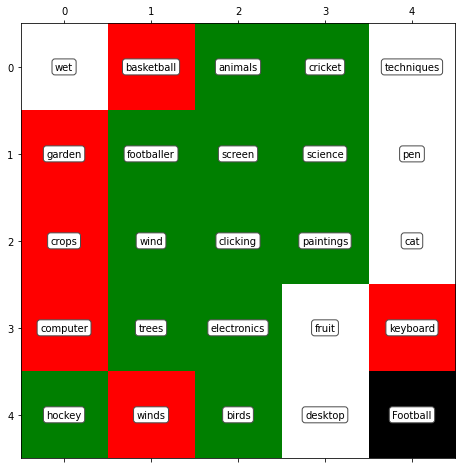

In [9]:
bg.print_grid(board, board_types)

In [10]:
y

('flowers', 4)

# Data generation

- Generate data
- coerce into approp format

In [11]:
bg = BoardGenerator(
    M=M,
    N=N,
    kv=kv,
    vocab=vocab,
    n_allied=n_allied,
    n_neutral=n_neutral,
    n_enemy=n_enemy,
    n_assassin=n_assassin,
    tile_types=tile_types,
    tile_type_scores=tile_type_scores,
)

bg_other = BoardGenerator(
    M=M,
    N=N,
    kv=kv,
    vocab=vocab2,
    n_allied=n_allied,
    n_neutral=n_neutral,
    n_enemy=n_enemy,
    n_assassin=n_assassin,
    tile_types=tile_types,
    tile_type_scores=tile_type_scores,
)

In [12]:
y_dict = {word: i for i, word in enumerate(vocab)}
y_dict_other = {word: i for i, word in enumerate(vocab2)}

board_type_dict = {tt: i for i, tt in enumerate(tile_types)}

In [13]:
def gen_samples(n_samples, bg):

    X = np.zeros((n_samples, M, len(bg.tile_types), N))

    board_list = list()
    board_topics_list = list()
    board_types_list = list()

    y_list = list()

    for i in tqdm(range(n_samples)):
        board, board_topics, board_types, y = bg.generate_board()

        # debug
        board_list.append(board)
        board_topics_list.append(board_topics)
        board_types_list.append(board_types)

        x = bg.get_repr(board)

        # TODO efficiency? not actually the slow bit :(
        x_types = [board_type_dict[tt] for tt in board_types]
        for j in range(M):
            card_vocab_dists = x[j]
            ind = x_types[j]
            X[i][j][ind] = card_vocab_dists

        y_list.append(y)

    return X, y_list, board_list, board_topics_list, board_types_list

In [14]:
X, y_list, board_list, board_topics_list, board_types_list = gen_samples(
    n_samples=20000, bg=bg
)

In [15]:
X_other, y_list_other, _, _, _ = gen_samples(n_samples=1000, bg=bg_other)

In [16]:
X.shape, X_other.shape

((20000, 25, 4, 5), (1000, 25, 4, 5))

In [17]:
y_word, y_num = zip(*y_list)
y_word = [y_dict[word] for word in y_word]
y_word = to_categorical(y_word)
y_num = to_categorical(y_num, num_classes=n_allied)


y_word_other, y_num_other = zip(*y_list_other)
y_word_other = [y_dict_other[word] for word in y_word_other]
y_word_other = to_categorical(y_word_other)
y_num_other = to_categorical(y_num_other, num_classes=n_allied)

In [18]:
X_flat = X.reshape((X.shape[0], -1))
X_other_flat = X_other.reshape((X_other.shape[0], -1))

## Train model

train a model to prove our input format isn't completely wrong

In [19]:
X_flat.shape, X_other_flat.shape

((20000, 500), (1000, 500))

In [21]:
y_word.shape, y_word_other.shape, y_num.shape, y_num_other.shape

((20000, 5), (1000, 5), (20000, 12), (1000, 12))

In [22]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
inds = np.expand_dims(np.arange(len(X)),1)
inds_rus, y_word_rus = rus.fit_sample(inds, y_word)
inds_rus = np.squeeze(inds_rus)
X_rus = X_flat[inds_rus]
y_num_rus = y_num[inds_rus]

/home/dev/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [23]:
X_rus.shape, y_word_rus.shape, y_num_rus.shape

((15110, 500), (15110, 5), (15110, 12))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_word_train, y_word_test, y_num_train, y_num_test = train_test_split(
    X_rus, y_word_rus, y_num_rus, test_size=0.1, stratify=y_word_rus
)

In [26]:
input_shape = X_rus.shape[1:]
print("input shape", input_shape)

input shape (500,)


In [27]:
inp = layers.Input(shape=input_shape, name="input")
dense_1 = layers.Dense(1000, activation="relu", name="layer1")(inp)
dense_word = layers.Dense(N, name="dense_word", activation=None)(dense_1)

concat = layers.concatenate((dense_1, dense_word), name="concat")

out_word = layers.Softmax(name="out_word")(dense_word)

out_num = layers.Dense(n_allied, name="out_num", activation="softmax")(concat)

model = keras.Model(inputs=(inp,), outputs=(out_word,out_num))

In [28]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 500)]        0                                            
__________________________________________________________________________________________________
layer1 (Dense)                  (None, 1000)         501000      input[0][0]                      
__________________________________________________________________________________________________
dense_word (Dense)              (None, 5)            5005        layer1[0][0]                     
__________________________________________________________________________________________________
concat (Concatenate)            (None, 1005)         0           layer1[0][0]                     
                                                                 dense_word[0][0]      

In [29]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, (y_word_train, y_num_train), batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
383/383 [==============================] - 2s 4ms/step - loss: 3.1202 - out_word_loss: 1.5610 - out_num_loss: 1.5591 - out_word_accuracy: 0.2828 - out_num_accuracy: 0.3263 - val_loss: 2.9885 - val_out_word_loss: 1.4557 - val_out_num_loss: 1.5328 - val_out_word_accuracy: 0.3684 - val_out_num_accuracy: 0.3294
Epoch 2/10
383/383 [==============================] - 1s 4ms/step - loss: 2.8126 - out_word_loss: 1.2926 - out_num_loss: 1.5200 - out_word_accuracy: 0.4789 - out_num_accuracy: 0.3473 - val_loss: 2.7310 - val_out_word_loss: 1.1870 - val_out_num_loss: 1.5440 - val_out_word_accuracy: 0.5272 - val_out_num_accuracy: 0.3279
Epoch 3/10
383/383 [==============================] - 1s 4ms/step - loss: 2.5228 - out_word_loss: 1.0301 - out_num_loss: 1.4927 - out_word_accuracy: 0.5968 - out_num_accuracy: 0.3714 - val_loss: 2.6460 - val_out_word_loss: 1.0993 - val_out_num_loss: 1.5467 - val_out_word_accuracy: 0.5419 - val_out_num_accuracy: 0.3096
Epoch 4/10
383/383 [====================

In [30]:
# eval on test set
model.evaluate(X_test, (y_word_test, y_num_test))

48/48 [==============================] - 0s 2ms/step - loss: 3.1244 - out_word_loss: 1.0866 - out_num_loss: 2.0378 - out_word_accuracy: 0.5963 - out_num_accuracy: 0.2919


[3.124411106109619,
 1.0865665674209595,
 2.037843942642212,
 0.5962938666343689,
 0.2918596863746643]

In [31]:
y_word_other.shape, y_num_other.shape

((1000, 5), (1000, 12))

In [32]:
# eval on held out set generated from separate vocab
model.evaluate(X_other_flat, (y_word_other, y_num_other))

32/32 [==============================] - 0s 2ms/step - loss: 3.3938 - out_word_loss: 1.3987 - out_num_loss: 1.9951 - out_word_accuracy: 0.5400 - out_num_accuracy: 0.2830


[3.393775701522827,
 1.3986653089523315,
 1.9951099157333374,
 0.5400000214576721,
 0.28299999237060547]